In [1]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 14:11:36--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [     <=>            ]  19.68M  21.7MB/s    in 0.9s    

2025-06-13 14:11:37 (21.7 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [9]:
pip install --upgrade groq

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [2]:
Groq_api_key = 'api_key'
client =Groq(api_key=Groq_api_key,http_client=None)

In [3]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [80]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""
        You are a Python pandas and matplotlib expert. Given this preprocessed dataframe (index=datetime):

        PREPROCESSING CODE:
    
         df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={{'datetime': {{'Date', 'Time'}}}},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

        df = df.dropna()
        df['Global_active_power'] = df['Global_active_power'].astype(float)
        df = df.set_index('datetime')
        
        Columns: {df_info_str}
        
        Generate ONLY executable Python/pandas code that:
        1. Answers the question: "{natural_language_question}"
        2. Stores final results in these standard variables when applicable:
           - avg_power_march, max_hour, weekday_avg, weekend_avg 
           - days_exceeded_5_kwh, daily_voltage, correlation
           - plot_data (for visualization outputs only)
        
        ONLY FOR VISUALIZATION QUERIES WHEN QUESTION CONTAINS KEY-WORDS like "plot", "visualize", "graph", "visualization":
            1. MUST include these elements in order:
               a) Data filtering/processing
               b) plt.figure() with size (10,6)
               c) ACTUAL PLOTTING COMMAND (plt.plot, plt.bar, etc.)
               d) Axis labels and title (plt.xlabel, plt.ylabel, plt.title)
               e) Save to "images/{model_name}/[sanitized_title].png"
               f) Buffer handling for plot_data
               g) plt.show()
               h) plt.close()
        
        EXAMPLE FOR QUESTION CONTAIN VISUALIZATION i.e "Plot the energy usage trend for the first week of January 2007."
        ```python
        # Filter data
        filtered = df[(df.index.year==2007) & (df.index.month==1)]
        daily = filtered['Global_active_power'].resample('D').mean()
        
        # Create plot
        plt.figure(figsize=(10,6))
        plt.plot(daily.index, daily, color='blue')  # <-- ACTUAL PLOT COMMAND
        plt.xlabel('Date')
        plt.ylabel('Power (kW)')
        title = 'January 2007 Daily Power Consumption'
        plt.title(title)
        
        # Save and store
        os.makedirs(f"images/{model_name}", exist_ok=True)
        filename = title.lower().replace(' ','_') + '.png'
        plt.savefig(f"images/{model_name}/filename.png")
        buf = io.BytesIO()
        buf.seek(0)
        plot_data = buf.getvalue()
        plt.show()
        plt.close()

        IMPORTANT RULES:
        (.)NEVER skip the actual plotting command (plt.plot, plt.bar, etc.) whereever needed if QUESTION CONTAIN KEY-WORDS.
        (.)show the plot (plt.show()) only for visual questions
        (.)Generate ONLY code - no explanations or markdown formatting
        (.)For non-visual questions, NEVER include plotting code AND ALWAYS PRINT THE FINAL RESULT.
    """
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [81]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}
    local_vars={}
    
    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec_vars={'df':df,'plt':plt}
        exec(fixed_code,exec_vars,local_vars) #execute the code in the context of the dataframe
        # Check if a plot was attempted but has 0 axes
        if 'plt' in exec_vars:
            fig = plt.gcf()
            if len(fig.axes) == 0 and any(line.strip().startswith(('plt.plot', 'plt.bar', 'plt.figure')) 
                                       for line in fixed_code.split('\n')):
                plt.close()
                print("Plot generation failed - empty figure detected")
                return False
        return True
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [6]:
df = load_data_set()

In [7]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [8]:
print(df.columns.tolist())
llama_results={}

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


# Consider for Analysis

In [11]:
#llama-3.3-70b-Versatile model testing

In [65]:
value= execute_query("What hour of the day had the highest power usage on Christmas 2006?","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["What hour of the day had the highest power usage on Christmas 2006?"]=1
else:
    llama_results["What hour of the day had the highest power usage on Christmas 2006?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Filter data for Christmas 2006
christmas_2006 = df[(df.index.year==2006) & (df.index.month==12) & (df.index.day==25)]
# Resample data by hour and calculate mean power usage
hourly_power = christmas_2006['Global_active_power'].resample('H').mean()
# Find the hour with the highest power usage
max_hour = hourly_power.idxmax()
# Store result in max_hour variable
max_hour = max_hour.hour
print(f"The hour with the highest power usage on Christmas 2006 is {max_hour}")
------------------------------------------------------------------------
Output of the code is:

The hour with the highest power usage on Christmas 2006 is 22
True


<Figure size 640x480 with 0 Axes>

In [67]:
value= execute_query("What was the average active power consumption in March 2007?","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["What was the average active power consumption in March 2007?"]=1
else:
    llama_results["What was the average active power consumption in March 2007?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Filter data for March 2007
march_2007 = df[(df.index.year==2007) & (df.index.month==3)]
# Calculate average active power consumption in March 2007
avg_power_march = march_2007['Global_active_power'].mean()
# Calculate average power consumption by hour of day
hourly_avg = df['Global_active_power'].resample('H').mean()
max_hour = hourly_avg.idxmax()
# Calculate average power consumption by day of week
weekday_avg = df['Global_active_power'].resample('D').mean().groupby(df.index.dayofweek < 5).mean()
weekend_avg = df['Global_active_power'].resample('D').mean().groupby(df.index.dayofweek >= 5).mean()
# Calculate days where power consumption exceeded 5 kWh
days_exceeded_5_kwh = df['Global_active_power'].resample('D').sum()[df['Global_active_power'].resample('D').sum() > 5].count()
# Calculate daily average voltage
daily_v

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Extract day of the week
df['day_of_week'] = df.index.dayofweek
# Create a new column to differentiate between weekdays and weekends
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
# Group by day type and calculate mean energy usage
energy_usage = df.groupby('day_type')['Global_active_power'].mean()
# Plot the result
energy_usage.plot(kind='bar')
---------------------------------------------------------------

<string>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


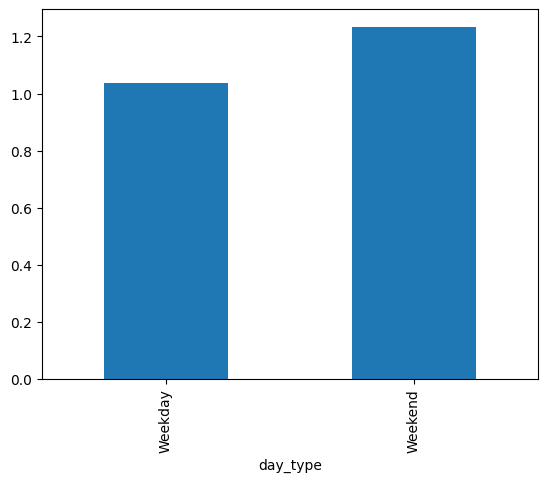

In [ ]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool","llama-3.3-70b-Versatile",df)

In [68]:
value= execute_query("Find days where total energy consumption exceeded 5 kWh.","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["Find days where total energy consumption exceeded 5 kWh"]=1
else:
    llama_results["Find days where total energy consumption exceeded 5 kWh"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Find days where total energy consumption exceeded 5 kWh
daily_energy = df['Global_active_power'].resample('D').sum() / 1000  # convert to kWh
days_exceeded_5_kwh = daily_energy[daily_energy > 5].index
# Calculate average power in March
avg_power_march = df['Global_active_power'].resample('M').mean().loc[2007, 3]
# Find the hour with the maximum power consumption
max_hour = df['Global_active_power'].resample('H').mean().idxmax()
# Calculate average power consumption on weekdays and weekends
weekday_avg = df['Global_active_power'].resample('D').mean().loc[df.index.weekday < 5].mean()
weekend_avg = df['Global_active_power'].resample('D').mean().loc[df.index.weekday >= 5].mean()
# Calculate daily voltage
daily_voltage = df['Voltage'].resample('D').mean()
# Calculate correlation between Global_active_power and Voltage
cor

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Filter data
filtered = df[(df.index.year==2007) & (df.index.month==1) & (df.index.day<=7)]
daily = filtered['Global_active_power'].resample('D').mean()
# Create plot
plt.figure(figsize=(10,6))
plt.plot(daily.index, daily, color='blue')  
title = 'first_week_january_2007_daily_power_consumption'
# Save and store
os.makedirs(f"images/llama-3.3-70b-Versatile", exist_ok=True)
filename = title.lower().replace(' ','_') + '.png'
buf = io.BytesIO()
plot_data = buf.getvalue()
# Aggregate data by month
monthly = df['Global_active_power'].resample('M').mean()
print(monthly)
------------------------------------------------------------------------
Output of the code is:

datetime
2006-12-31    1.901295
2007-01-31    1.546034
2007-02-28    1.401084
2007-03-31    1.318627
2007-04-30    0.891189
2007-05-31    0.985862
2007-06-30    

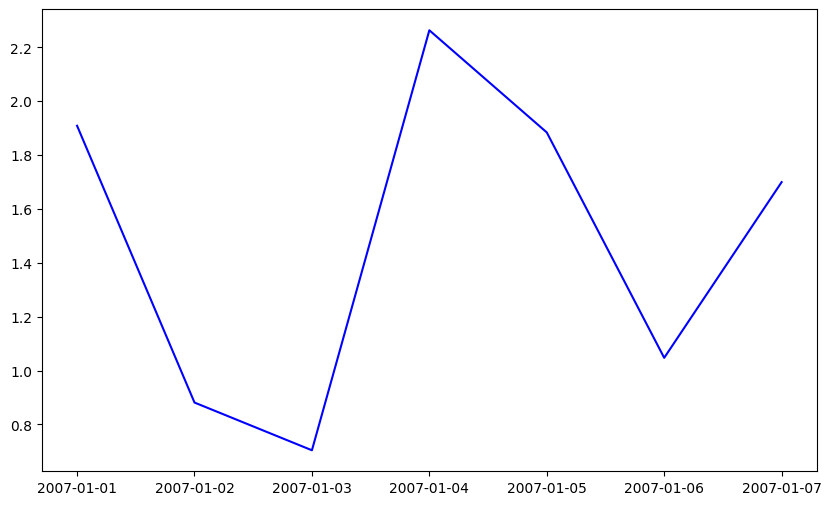

In [86]:
value= execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month"]=1
else:
    llama_results["Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month"]=0
print(value)

In [82]:
value= execute_query("Find the average voltage for each day of the first week of February 2007","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["Find the average voltage for each day of the first week of February 2007"]=1
else:
    llama_results["Find the average voltaga for each day of the first week of February 2007"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for the first week of February 2007
filtered = df[(df.index.year==2007) & (df.index.month==2) & (df.index.day<=7)]
# Calculate average voltage for each day
daily_voltage = filtered['Voltage'].resample('D').mean()
# Print the final result
print(daily_voltage)
# Since this is not a visualization question, no plot is generated
------------------------------------------------------------------------
Output of the code is:

datetime
2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Freq: D, Name: Voltage, dtype: float64
True


<Figure size 640x480 with 0 Axes>

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Calculate correlation between global active power and sub-metering values
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print correlation matrix
print(correlation)
# Filter data for visualization
filtered = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
# Create plot
plt.figure(figsize=(10,6))
plt.plot(filtered.index, filtered['Global_active_power'], label='Global Active Power')
plt.plot(filtered.index, filtered['Sub_metering_1'], label='Sub Metering 1')
plt.plot(filtered.index, filtered['Sub_metering_2'], label='Sub Metering 2')
plt.plot(filtered.index, filtered['Sub_metering_3'], label='Sub Metering 3')
# Save and store
os.makedirs(f"images/llama-3.3-70b-Versatile", exist_ok=True)
filename = 'global_active_power_and_sub_me

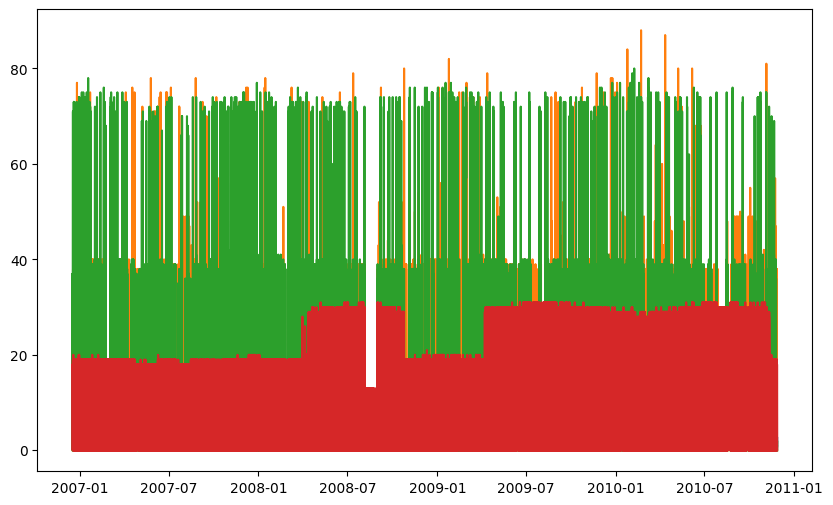

In [83]:
value= execute_query("What is the correlation between global active power and sub-metering values?.","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["What is the correlation between global active power and sub-metering values?"]=1
else:
    llama_results["What is the correlation between global active power and sub-metering values?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Calculate correlation between global active power and sub-metering values
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print correlation
print(correlation)
# Filter data for visualization
filtered = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
# Create plot
plt.figure(figsize=(10,6))
plt.plot(filtered.index, filtered['Global_active_power'], label='Global Active Power')
plt.plot(filtered.index, filtered['Sub_metering_1'], label='Sub Metering 1')
plt.plot(filtered.index, filtered['Sub_metering_2'], label='Sub Metering 2')
plt.plot(filtered.index, filtered['Sub_metering_3'], label='Sub Metering 3')
# Save and store
os.makedirs(f"images/llama-3.3-70b-Versatile", exist_ok=True)
filename = 'global_active_power_and_sub_metering_

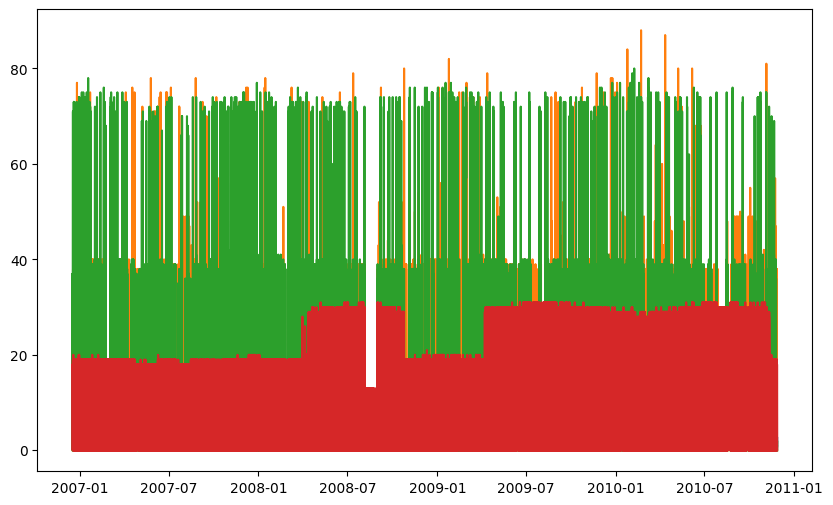

In [84]:
value= execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=1
else:
    llama_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=0

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for the first week of February 2008
df_filtered = df[(df.index.year == 2008) & (df.index.month == 2) & (df.index.day <= 7)]
# Group by day and calculate average voltage
average_voltage = df_filtered['Voltage'].resample('D').mean()
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64


In [ ]:
execute_query("Find days where energy consumption exceeded 2 kWh in 2008","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for 2008
df_2008 = df[df.index.year == 2008]
# Calculate daily energy consumption
daily_consumption = df_2008['Global_active_power'].resample('D').sum() / 1000  # Convert to kWh
# Find days where energy consumption exceeded 2 kWh
days_exceeded = daily_consumption[daily_consumption > 2]
print(days_exceeded)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2008-01-01    2.759738
2008-01-04    2.291852
2008-01-05    2.183248
2008-01-08    2.043550
2008-01-12    2.871408
                ...   
2008-12-17    2.098786
2008-12-20    2.242502
2008-12-21    2.643610
2008-12-22    2.015808
2008-12-27    2.972164
Name: Global_active_power, Length: 74, dtype: float64


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Filter data
filtered = df[(df.index.year==2007) & (df.index.month==1) & (df.index.day <= 7)]
daily = filtered['Global_active_power'].resample('D').mean()
# Create plot
plt.figure(figsize=(10,6))
plt.plot(daily.index, daily, color='blue')  
title = 'first week of january 2007 daily power consumption'
# Save and store
os.makedirs(f"images/llama-3.3-70b-Versatile", exist_ok=True)
filename = title.lower().replace(' ','_') + '.png'
buf = io.BytesIO()
plt.savefig(buf, format='png')
plot_data = buf.getvalue()
------------------------------------------------------------------------
Output of the code is:

True


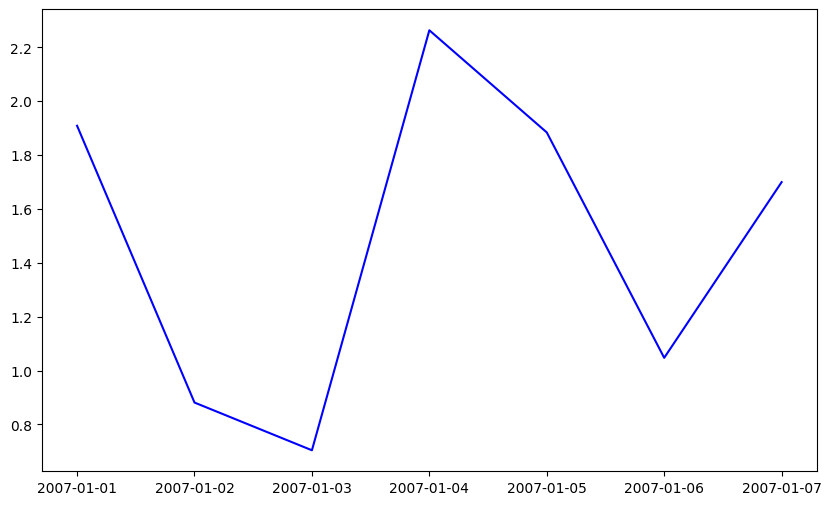

In [85]:
value = execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=1
else:
    llama_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import os
import io
# Calculate weekday and weekend averages
df['day_of_week'] = df.index.dayofweek
weekday_avg = df[df['day_of_week'] < 5]['Global_active_power'].mean()
weekend_avg = df[df['day_of_week'] >= 5]['Global_active_power'].mean()
# Print results
print("Weekday average energy usage:", weekday_avg)
print("Weekend average energy usage:", weekend_avg)
# Visualize the comparison
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Global_active_power'], color='blue', alpha=0.5, label='Energy usage')
plt.plot(df.index, [weekday_avg if day < 5 else weekend_avg for day in df['day_of_week']], color='red', label='Weekday/Weekend average')
# Save and store
os.makedirs(f"images/llama-3.3-70b-Versatile", exist_ok=True)
filename = 'weekday_vs_weekend_energy_usage.png'
buf = io.BytesIO()
plt.savefig(buf, format='png')
plot_data = buf.getvalue()


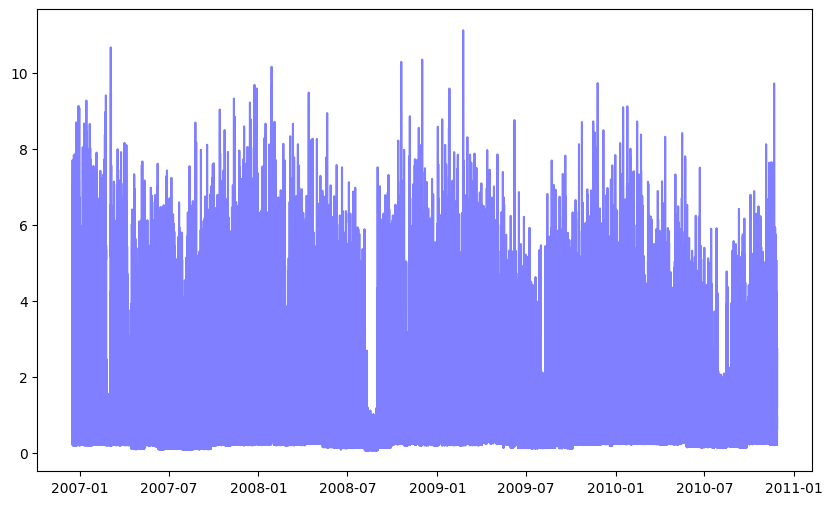

In [88]:
value= execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends.","llama-3.3-70b-Versatile",df)
if(value):
    llama_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=1
else:
    llama_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=0
print(value)

In [4]:
for k,v in llama_results.items():
    print(k,": ",v)

What was the average active power consumption in March 2007? :  0
What hour of the day had the highest power usage on Christmas 2006? :  1
Compare energy usage (Global_active_power) on weekdays vs weekends :  1
Find days where total energy consumption exceeded 5 kWh :  0
Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month :  1
Find the average voltage for each day of the first week of February 2007 :  1
What is the correlation between global active power and sub-metering values? :  1
What is the correlation between global active power and sub-metering values?. Can you show it using visualization :  1
Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day :  1


In [3]:
%store llama_results

Stored 'llama_results' (dict)
